### car racing - torch

In [1]:
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
import gym
import pylab as p
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)

        return state, action, reward, next_state, done



# CNN 특성 추출기
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.linear = nn.Linear(64 * 64, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear(x))
        return x

class QNet(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.feature = CNNFeatureExtractor()

        # 나머지 레이어들
        self.l1 = nn.Linear(128, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = self.feature(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

Observation Space: Box(0, 255, (96, 96, 3), uint8)
Action Space: Discrete(5)
Episode 0 | Total Reward -61.30701754386013
Episode 10 | Total Reward -42.02898550724715
Episode 20 | Total Reward -29.629629629630433
Episode 30 | Total Reward -68.75000000000054
Episode 40 | Total Reward -59.107806691450484
Episode 50 | Total Reward -36.90851735015847
Episode 60 | Total Reward -62.71186440678024
Episode 70 | Total Reward -60.714285714286405
Episode 80 | Total Reward -63.08724832214842
Episode 90 | Total Reward -35.48387096774241
Episode 100 | Total Reward -65.51724137931117
Episode 110 | Total Reward -67.39130434782645
Episode 120 | Total Reward -65.51724137931079
Episode 130 | Total Reward -57.52895752895802
Episode 140 | Total Reward -71.63120567375901
Episode 150 | Total Reward -76.97368421052633
Episode 160 | Total Reward -69.135802469136
Episode 170 | Total Reward -42.424242424242784
Episode 180 | Total Reward -63.89891696750973
Episode 190 | Total Reward -56.65634674922653
Episode 200 

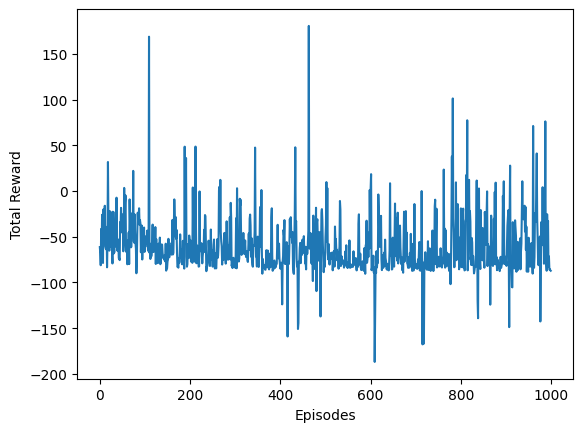

In [3]:
class DQNAgent:
    def __init__(self, device='cpu'):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 1000
        self.batch_size = 32
        self.action_size = 5
        self.device = device

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size).to(self.device)
        self.qnet_target = QNet(self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=self.lr)


    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]
            state = torch.tensor(state, dtype=torch.float32, device=self.device)

            with torch.no_grad():
                qs = self.qnet(state)
            return qs.argmax(dim=1).item()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        action = torch.tensor(action, dtype=torch.long).to(self.device)
        reward = torch.tensor(reward, dtype=torch.float32).to(self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
        done = torch.tensor(done, dtype=torch.float32).to(self.device)

        qs = self.qnet(state)
        q = qs[torch.arange(self.batch_size), action]

        with torch.no_grad():
            next_qs = self.qnet_target(next_state)
            next_q = next_qs.max(1)[0]
            target = reward + (1 - done) * self.gamma * next_q

        loss = F.mse_loss(q, target)

        self.qnet.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sync_qnet(self):
        self.qnet_target.load_state_dict(self.qnet.state_dict())


def preprocess(state):
    state = np.transpose(state, (2, 0, 1))
    state = state / 255.0
    return state



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
episodes = 1000
sync_interval = 10


env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
agent = DQNAgent(device=device)

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

input_dim = env.observation_space.shape[0]

reward_history = []

for episode in range(episodes):
    state = env.reset()[0]
    state = preprocess(state)
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = preprocess(next_state)
        done = terminated or truncated

        agent.update(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode} | Total Reward {total_reward}")

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.plot(range(len(reward_history)), reward_history)
plt.show()

In [4]:

torch.save(agent.qnet.state_dict(), "CarRacing_model_qnet.h5")
torch.save(agent.qnet_target.state_dict(), "CarRacing_model_qnet_target.h5")


In [3]:
agent2 = DQNAgent(device=device)
agent2.qnet.load_state_dict(torch.load("CarRacing_model_qnet.h5"))
agent2.qnet_target.load_state_dict(torch.load("CarRacing_model_qnet_target.h5"))

<All keys matched successfully>

In [4]:
env2 = gym.make('CarRacing-v2', continuous=False, render_mode='human')
state, info = env2.reset()

agent2.epsilon = 0
state = env.reset()[0]
state = preprocess(state)


done = False
total_reward = 0

while not done:
    action = agent2.get_action(state)
    next_state, reward, terminated, truncated, info = env2.step(action)
    done = terminated | truncated

    next_state = preprocess(next_state)
    state = next_state
    total_reward += reward
    env2.render()
print(f"Total Reward: {total_reward}")


Total Reward: -92.50936329587915
